# Semester Project 
## Cache-Friendly Recommender with reinforcement learning
#### IAKIMOVA Iuliia
#### BARTHELEMY Jeanne

This notebook will allow us to test our code, visualize the efficiency of our agent and test hyperparameters.

In [ ]:
#Libraries 

import numpy as np
import random
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from torch import nn
import copy 

## Items

In [ ]:
#We define here a simplified environnement for our problem : Items part
#Just the list of items, with similarities and cost

class Items(): #part of the environnement directly dealing with items (database, costs, similariries)
    def __init__(self, N_items):

        #Creating the database of all of the items
        # (ex: one item is one song)
        self.n_items = N_items
        self.items = []
        self.ids = [] #we only have the ids of the items displayed here
        self.similarities = np.zeros((self.n_items,self.n_items))
        self.createItems()
        self.computeSimilarities()

    def createItems(self):
        for i in range(self.n_items):
            item = Item(i,random.randint(3,9))
            self.items.append(item)
            self.ids.append(i)


    def computeSimilarities(self):
        for i in tqdm(range(self.n_items)):
            for j in range(self.n_items):
                if i==j:
                    self.similarities[i][j]=1
                elif j>i:
                    self.similarities[i][j] = random.random()
                else:
                    self.similarities[i][j] = self.similarities[j][i]

    def display(self, print_items = False, print_similarities = False ):
        print("---------------- Items ----------------")
        print("Number of items: "+str(self.n_items))
        if print_items:
            print("*** Items list: ***")
            for item in self.items:
                item.display()
            print("***************")
        if print_similarities:
            print("*** Similarities: ***")
            print(self.similarities)
            print("***************")

class Item(): #a single item of the items database
    def __init__(self, id , size="7", binary = True, name = 'none'):

        self.id = id
        if name == 'none':
            self.name = RandomName(size)
        elif name != 'none':
            self.name = name

        if binary: #cached = 0, not cached = 1
            # Parameter can be changed (proportion of cached content)
            self.cost = int(np.random.choice([0,1], p = [0.05,0.95])) #Only a minority of items is cached
        elif binary == False: #real numbers for costs
            self.cost = 100*random.random()

    def display(self):
        print("Item "+str(self.id)+" -> name:" +self.name+", cost: "+str(self.cost))


def RandomName(size):
    alphabet = "AZERTYUIOPMLKJHGFDSQWXCVBNazertyuiopmlkjhgfdsqwxcvbn7894561230"
    name = ""
    for i in range(size):
        name = name + random.choice(alphabet)
    return name

## User

In [ ]:
class Customer():
    def __init__(self, items, recommendation, behaviour = 'random' , p_or_minSum = 0.7, specific_items = None): #p is the probability to trust
        #The customer has this way a direct access to
        self.items = items
        self.recommendation = recommendation
        if behaviour == 'specific':
            self.specific_items = specific_items
        #This would make us always choose the same beginning state.
        #self.previous_choice_id = -1
        #self.choice_id = -1 #it will be updated to the id of the next choice

        #Let's instead choose a random first state:
        self.previous_choice_id = random.randint(0, self.items.n_items -1)
        self.choice_id = random.randint(0, self.items.n_items -1)
        while   self.choice_id == self.previous_choice_id:
            self.choice_id = random.randint(0, self.items.n_items -1)

        self.trust_recommendation = False #If trust recommendations, this will be updated to True
        self.behaviour = behaviour

        if self.behaviour == 'similarWithSubset':
            self.min_similarity_sum = p_or_minSum #in this case, the p_or_minSum variable can be any real number

        else:
            self.p = p_or_minSum
            #Here p is a probability that has to be between 0 and 1 ... the lines below are ensuring that
            if self.p <0 :
                self.p =0
            elif self.p >1 :
                self.p = 1

        #List used for debugging
        self.choicesThisEpisode = np.zeros(self.items.n_items)

    def choice(self):
        if self.behaviour == 'similar':
            self.choiceSimilar()

        elif self.behaviour == "similarWithSubset":
            self.choiceSimilarWithSubset()

        else:
            print("Error: no choice method indicated")
        self.choicesThisEpisode[self.choice_id] += 1

    def endEpisode(self):
        self.previous_choice_id = random.randint(0, self.items.n_items -1)
        self.choice_id = random.randint(0, self.items.n_items -1)
        while   self.choice_id == self.previous_choice_id:
            self.choice_id = random.randint(0, self.items.n_items -1)
        self.trust_recommendation = False
        self.choicesThisEpisode = np.zeros(self.items.n_items)

    def display(self, print_item = False):
        print("----------- Customer -----------")
        print("Trust recommendation: "+str(self.trust_recommendation))
       # print(" Previous choice: "+str(self.previous_choice_id))
        print(" Choice: "+str(self.choice_id))
        if print_item:
            self.items.items[self.choice_id].display()

    def choiceSimilar(self): #this user has a minimum standard of "quality", being the similarities
        self.trust_recommendation = False
        self.previous_choice_id = self.choice_id
        for id in self.recommendation.recommended_items :
            if self.items.similarities[id][self.choice_id] >= self.p and not self.trust_recommendation:
                self.trust_recommendation = True
                self.choice_id = id
                break
        if not self.trust_recommendation: #Choose randomly among the 2 items with best similarity
            similarities = self.items.similarities[self.choice_id]
            self.choice_id = np.random.choice(similarities.argsort()[- 3 :])   #/!\ with big lists, problems...
            while self.choice_id == self.previous_choice_id :
                self.choice_id = np.random.choice(similarities.argsort()[- 3 :])

    def choiceSimilarWithSubset(self): #This user behaviour will be usable with the deep learning "faster" method
        #Contrary to "Similar" user, it is scalable to huge catalogs of items
        recommendation_similarities = [self.items.similarities[id][self.choice_id] for id in self.recommendation.recommended_items ]
        recommendation_similarities_sum = np.sum(np.array(recommendation_similarities))
        #print(self.min_similarity_sum, recommendation_similarities_sum)
        #TODO : set this to mean instead later maybe?
        if self.min_similarity_sum <= recommendation_similarities_sum :
            #The recommendation is globally good enough:
            self.trust_recommendation = True #We will pick an item into the recommendations
            self.choice_id = int(np.random.choice(self.recommendation.recommended_items, 1, p =softmaxOfSims(recommendation_similarities)))
            #We will pick this item with the similarities as the probabilities (with softmax transformation)

        else:
            self.trust_recommendation = False
            self.previous_choice_id = self.choice_id

    #To adapt to huge dataset, we will take the best option out of a subset of items
    #Indeed, this is more realistic: a user would not see all of the descriptions of the items  in youtube before making a choice.
    #The user would rather have a look at a smaller subset and make a choice within this smaller subset
            random_subset = np.random.choice(self.items.ids, min(self.items.n_items, 10), replace=False) #Random item ids
            #TODO : change the random subset size later
            random_subset_similarities = np.array([self.items.similarities[id][self.choice_id] for id in random_subset]) #The similarities of the random items ids
            while self.previous_choice_id == self.choice_id:  # To ensure we wont take two time the same item
                random_item_sim = np.random.choice(random_subset_similarities.argsort()[- 3:])
                self.choice_id =  int(random_subset[random_item_sim])
        #We randomly took one of the 3 items with the best similarity, in the random subset of items


#helper function :

def softmaxOfSims(similarities): #to change similarities into probabilities
    np_sims = np.array(similarities)
    exponential_similarities = np.exp(np_sims)
    return list(exponential_similarities/np.sum(exponential_similarities))


## Recommendations 

In [ ]:
class Recommendation(): #part of the environnement directly dealing with recommended items
    #no agent/AIfor the moment. The choice of the ids will be determined by the agent.
    def __init__(self,items, N_recommended): #items is an Items object, N_recommended the number of recommendations

        #About the recommended items
        #(the list will be updated)
        self.n_recommended =   N_recommended
        self.recommended_items = [] #list of ids of recommended items
        self.all_items = items #list of ALL items

        # List used for debugging
        self.choicesThisEpisode = np.zeros(self.all_items.n_items)

    def recommend(self, ids): #assume we have a list of ids, we just update the list
        if len(ids) != self.n_recommended:
            print("ERROR : you must recommend exactly "+str(self.n_recommended)+ " items.")
        else:
            self.recommended_items = ids
        self.choicesThisEpisode[self.recommended_items] += 1

    def endEpisode(self):
        self.recommended_items = []
        self.choicesThisEpisode = np.zeros(self.all_items.n_items)

    def display(self, print_items = False):
        print("---------------- Recommendations ----------------")
        print("Number of recommended items: "+str(self.n_recommended))
        if print_items:
            print("*** Items list: ***")
            for item_id in self.recommended_items:
                self.all_items.items[item_id].display()
            print("***************")

## Environment 

In [ ]:
class Environnement():
    def __init__(self, N_items, N_recommended,behaviour="random", rewardType = 'trust', rewardParameters = [1,1] ,  proba_p = 0.7 ,  specific_items = None, name = 'envi_01'): #proba_p for ramdom choice (customer)
        self.items = Items(N_items)
        self.recommendation = Recommendation(self.items, N_recommended)
        self.customer = Customer( self.items, self.recommendation, behaviour, proba_p , specific_items)
        self.name = name
        self.rewardType = rewardType
        self.rewardParameters = rewardParameters

    def endEpisode(self):
        self.customer.endEpisode()
        self.recommendation.endEpisode()

    #self.step to simulate new step of the environnement
    def step(self, agentRecommendation): #here agentRecommendation is the items recommended by the agent
        self.recommendation.recommend(agentRecommendation) #We have set the new recommendations
        self.customer.choice()
        reward = self.computeReward()
        return reward



    def computeReward(self):#This function will be refined to get more realistic rewards
        if self.rewardType == 'Similarity':
            reward = -self.items.items[self.customer.choice_id].cost * self.rewardParameters[0]
            reward += self.items.similarities[self.customer.previous_choice_id][self.customer.choice_id] * self.rewardParameters[1]
        elif self.rewardType == 'Trust':
            reward = -(self.items.items[self.customer.choice_id].cost )* self.rewardParameters[0]
            reward += self.customer.trust_recommendation * self.rewardParameters[1]
        else:
            print("Error : wrong reward type")
            return None

        return reward

    def display(self, print_item = False):
        print('---------ENVIRONNEMENT DISPLAY--------')
        self.items.display(print_item)
        self.recommendation.display()
        self.customer.display()

## Q-Learning (Action Tuples)

In [ ]:
#Same thing than the Qlearning class, but with more complex actions.
#Indeed, before, one action was one item, now an action is a tuple (of all the recommended items).
class QlearningActionTuples():
    #items_size is the number of items, memory the "memory" hyperparameter to define the states.
    def __init__(self, agent, items_size, memory, N_recommended,epsilon = 0.1 ,learning_rate = 0.7, gamma = 0.3, choiceMethod = "eGreedy"):
        self.N_recommended = N_recommended
        self.agent = agent
        self.actions, self.actions_ids = self.initActions()
        self.numActions = len(self.actions_ids)
        self.dims =  [items_size for i in range(memory)]+[self.numActions] #the +1 for the actions
        self.initQtable()
        self.lr = learning_rate
        self.choiceMethod = choiceMethod
        self.epsilon = epsilon
        self.gamma = gamma
        self.recommendation =  [] #will be updated  (the id of the choice)


    def initActions(self): #helper function to compute the actions possibilities
        def computeActions(n,li):
            if n==1 :
                return li
            else :
                li = [prev+ [j] for prev in li for j in self.agent.environnement.items.ids if j not in prev ]
                return computeActions(n-1, li)

        actions = computeActions(self.N_recommended,[[i] for i in self.agent.environnement.items.ids] )
        return (actions,[i for i in range(len(actions))])




    def initQtable(self): #We have to initialize the Qtable (and remove the possibility of recommending the currently watched item)
        #self.Qtable = np.ones(self.dims)  # not flattened Qtable. Optimistic values (ones) to encourage exploration at the beginning.
        #self.Qtable = np.ones(self.dims)
        # Or we can also set everything to 0
        self.Qtable = np.zeros(self.dims)
        for lastState in range(self.dims[-2]):
            for action_id in self.actions_ids :
                if lastState in self.actions[action_id]:
                    self.Qtable[..., lastState, action_id] = -np.inf


        # For instance, Qtable[0][5][3] would allow us to get the list of values for actions, for the state [0,5,3] (if memory = 3)

    def chooseAction(self, train_): #When we are in a new state, we get to choose a new action
        if train_ : #a training session : we choose the choice method specific to training sessions
            if self.choiceMethod == "eGreedy" :
                self.chooseActionEGreedy()
            else:
                print("Error : Qlearning Choice Method not recognized")
        else: #not a training session
            self.recommendation_id = self.chooseMaxAction(self.agent.state, 1)[0]
            self.recommendation = self.actions[self.recommendation_id]


    def chooseActionEGreedy(self):
        self.recommendation = []
        rand_ = random.random()
        if rand_ <= self.epsilon:
            self.chooseActionRandom()

        else:
            self.recommendation_id = self.chooseMaxAction(self.agent.state, 1)[0]
            self.recommendation = self.actions[self.recommendation_id]


    def chooseActionRandom(self):
        recommendation_id = np.random.choice(self.actions_ids)
        while self.agent.environnement.customer.choice_id in self.actions[recommendation_id]:
            recommendation_id = np.random.choice(self.actions_ids)
        self.recommendation_id = recommendation_id
        self.recommendation = self.actions[self.recommendation_id][:]

    #(We need to update this function to add randomness! (not select the n_recommended higher in the order of their id...)
    def chooseMaxAction(self, state, num):
       # self.Qtable[tuple(state)][state[-1]] = -np.inf  #to make sure we wont recommend the currently watched item
        #return (np.flip(self.Qtable[tuple(state)]).argsort()[- num :])
        return self.selectRandomlyMax(np.copy(self.Qtable[tuple(state)][:]), num, [])

    def train(self, print_ = False):   #/!\ to update
        if print_:
            self.display()

        prev_state_reco = self.Qtable[tuple(self.agent.previousState)][self.recommendation_id]
        current_state_max = self.Qtable[tuple(self.agent.state)][self.chooseMaxAction(self.agent.state, 1)][0]
        self.Qtable[tuple(self.agent.previousState)][self.recommendation_id] = prev_state_reco + self.lr * (self.agent.reward + self.gamma * current_state_max - prev_state_reco)

    def endEpisode(self):
        self.recommendation = []

    def display(self):
        print("--------------------------> Q learning (tuple actions) method :")
        print(" learning rate: "+str(self.lr))
        print(" gamma: "+str(self.gamma))
        print(">>>>> Qtable <<<<<")
        print(self.Qtable)

    def selectRandomlyMax(self, li, n, results): #select randomly n maximums in an np.array list. Returns indices.
        if n == 0:
            return np.array(results)
        else :
            max_ = np.max(li)
            ind = np.argwhere(li == max_).flatten()
            choice = np.random.choice(ind)
            results.append(choice)
            li[choice] = -np.inf
            return self.selectRandomlyMax(li, n-1, results)

## Q-Learning (Linear)

In [ ]:
class LinearQlearning():
    #items_size is the number of items, memory the "memory" hyperparameter to define the states.
    def __init__(self, agent, N_items, Memory, N_recommended, epsilon = 0.1 ,learning_rate = 0.7, gamma = 0.3, choiceMethod = "eGreedy"):
        self.n_recommended = N_recommended
        self.memory = Memory
        self.n_items = N_items
        self.n_inputs = self.memory + 2*self.n_recommended # TODO : adapt the self.n_inputs to the right value
        self.weights = np.random.rand(self.n_inputs,1)  #The weights that will be used to estimate the state value
        self.agent = agent
        self.actions, self.actions_ids = self.initActions()
        self.numActions = len(self.actions_ids)
        self.lr = learning_rate
        self.choiceMethod = choiceMethod
        self.epsilon = epsilon
        self.gamma = gamma
        self.recommendation =  [] #will be updated  (the id of the choice)




          # For instance, Qtable[0][5][3] would allow us to get the list of values for actions, for the state [0,5,3] (if memory = 3)


    def chooseAction(self, train_): #When we are in a new state, we get to choose a new action
        if train_ : #a training session : we choose the choice method specific to training sessions
            if self.choiceMethod == "eGreedy" :
                self.chooseActionEGreedy()
            else:
                print("Error : Qlearning Choice Method not recognized")
        else: #not a training session
            self.recommendation = self.chooseMaxAction(self.agent.state)[0]
        self.recommendation_id = self.actions.index(self.recommendation)

    def chooseActionEGreedy(self):
        self.recommendation = []
        rand_ = random.random()
        if rand_ <= self.epsilon:
            self.recommendation = self.chooseMaxAction(self.agent.state)[0]
            self.chooseActionRandom()
        else:
            self.recommendation = self.chooseMaxAction(self.agent.state)[0]



    def chooseActionRandom(self):
        #We already have chosen the recommendation, according to the "chooseMaxAction" function.
        # But one of the items is going to be changed, so that it can be chosen randomly.
        random_recommendation = np.random.randint(0, self.n_items)
        while self.agent.environnement.customer.choice_id == random_recommendation or random_recommendation in self.recommendation:
            random_recommendation = np.random.randint(0, self.n_items)
        index = np.random.randint(0,self.n_recommended)
        self.recommendation[index] = random_recommendation


    def initActions(self): #helper function to compute the actions possibilities
        def computeActions(n,li):
            if n==1 :
                return li
            else :
                li = [prev+ [j] for prev in li for j in self.agent.environnement.items.ids if j not in prev ]
                return computeActions(n-1, li)

        actions = computeActions(self.n_recommended,[[i] for i in self.agent.environnement.items.ids] )
        return (actions,[i for i in range(len(actions))])


    def chooseMaxAction(self, state):
        #This function could be improved in order to be "parallelized", or more efficient.
        #However, this work is mainly for theoritical study, we are letting aside the
        # 'efficiency' aspect of the code for the moment
        current_item = self.agent.environnement.customer.choice_id
        best_indice = None
        best_value = -np.inf
        for i in self.actions_ids:
            action = self.actions[i][:]
            if current_item not in action:
                value = self.getValue(state,action)
                if value > best_value:
                    best_indice = i
                    best_value = value
        return  self.actions[best_indice][:] , best_value

    # In the logistic-inspired model, this is just the matrix multiplication.
    def getValue(self,state,action):
        return np.dot(np.array(self.getInput(state,action)), self.weights)[0]

    # Here we "transform" the input in order to get costs and similarities, instead of item id, as an input
    #TODO : see why the basic item_id inputs was not working at all
    def getInput(self, state, action):
        input = []
        #Adding costs of states in memory:
        for item_id in state:
            input.append(self.agent.environnement.items.items[item_id].cost)
        # Adding costs of items of the action:
        for item_id in action:
            input.append(self.agent.environnement.items.items[item_id].cost)
        #Adding similarities of the last state with all items in action
        for item_id in action:
            input.append(self.agent.environnement.items.similarities[state[-1]][item_id])
        #print(state,action,  input)
        return input



    def train(self, print_ = False):   #/!\ to update
        if print_:
            self.display()

        #The TD error
        current_state_value = self.chooseMaxAction(self.agent.state)[1]
        last_state_value = self.getValue(list(self.agent.previousState), self.recommendation)
        delta = self.agent.reward + self.gamma * current_state_value - last_state_value

        #Finally, the gradient descent update
        self.weights = self.weights + self.lr*delta*np.array(self.getInput(list(self.agent.previousState), self.recommendation)).reshape(self.n_inputs,1)

    def endEpisode(self):
        self.recommendation = []

    def display(self, print_actions = False):
        print("--------------------------> Q learning (simple Linear approximation) method :")
        print(" memory: " + str(self.memory))
        print(" number of items to recommend at each step : " + str(self.n_recommended))
        print(" learning rate: "+str(self.lr))
        print(" gamma: "+str(self.gamma))
        print("Weights: ")
        print(self.weights)
        if print_actions:
            print(self.actions)

#Helper functions

## Q-Learning (Deep) 



In [ ]:
#In this file, we implement the Qlearning method, but using function approximation.
#This is a neural network. The trainable parameters are the bias and weight tensor of each "trainable" layer
# state - action values .
# off-policy TD control
#Mathematical understanding/formula used : we can have a look at https://towardsdatascience.com/function-approximation-in-reinforcement-learning-85a4864d566

import random
import numpy as np
import torch




#Same thing than the Qlearning class, but with more complex actions.
#Indeed, before, one action was one item, now an action is a tuple (of all the recommended items).
class DeepQlearning():
    #items_size is the number of items, memory the "memory" hyperparameter to define the states.
    def __init__(self, agent,  N_items, Memory, N_recommended, epsilon = 0.1 ,learning_rate = 0.7, gamma = 0.3, choiceMethod = "eGreedy", optimize_time = True):
        self.n_recommended = N_recommended
        self.memory = Memory
        self.n_items = N_items
        self.n_inputs = self.memory + 2*self.n_recommended
        self.agent = agent
        self.actions, self.actions_ids = self.initActions()
        self.numActions = len(self.actions_ids)
        self.lr = learning_rate
        self.choiceMethod = choiceMethod
        self.epsilon = epsilon
        self.gamma = gamma
        self.recommendation =  [] #will be updated  (the id of the choice)

        # Last minute upgrade to optimize computation time
        self.last_5_states = None
        self.last_5_states_values = None
        if optimize_time:
            self.last_5_states = [] #In this list is kept the 5 last visited items
            self.last_5_states_values = []  #In this list is kept the values of the 5 last visited items


    def setModel(self, Model,Trainable_layers): #A separate step, so that we can have the input size from the Qlearning __init__
        self.model = Model
        self.trainable_layers = Trainable_layers
          # For instance, Qtable[0][5][3] would allow us to get the list of values for actions, for the state [0,5,3] (if memory = 3)


    def chooseAction(self, train_): #When we are in a new state, we get to choose a new action
        if train_ : #a training session : we choose the choice method specific to training sessions
            if self.choiceMethod == "eGreedy" :
                self.chooseActionEGreedy()
            else:
                print("Error : Qlearning Choice Method not recognized")
        else: #not a training session
            self.recommendation = self.chooseMaxAction(self.agent.state)[0]
        self.recommendation_id = self.actions.index(self.recommendation)

    def chooseActionEGreedy(self):
        self.recommendation = []
        rand_ = random.random()
        if rand_ <= self.epsilon:
            self.recommendation = self.chooseMaxAction(self.agent.state)[0]
            self.chooseActionRandom()
        else:
            self.recommendation = self.chooseMaxAction(self.agent.state)[0]



    def chooseActionRandom(self):
        #We already have chosen the recommendation, according to the "chooseMaxAction" function.
        # But one of the items is going to be changed, so that it can be chosen randomly.
        random_recommendation = np.random.randint(0, self.n_items)
        while self.agent.environnement.customer.choice_id == random_recommendation or random_recommendation in self.recommendation:
            random_recommendation = np.random.randint(0, self.n_items)
        index = np.random.randint(0,self.n_recommended)
        self.recommendation[index] = random_recommendation


    def initActions(self): #helper function to compute the actions possibilities
        def computeActions(n,li):
            if n==1 :
                return li
            else :
                li = [prev+ [j] for prev in li for j in self.agent.environnement.items.ids if j not in prev ]
                return computeActions(n-1, li)

        actions = computeActions(self.n_recommended,[[i] for i in self.agent.environnement.items.ids] )
        return (actions,[i for i in range(len(actions))])


    def chooseMaxAction(self, state):
        #This function could be improved in order to be "parallelized", or more efficient.
        #However, this work is mainly for theoritical study, we are letting aside the
        # 'efficiency' aspect of the code for the moment
        current_item = self.agent.environnement.customer.choice_id
        best_indice = None
        best_value = -np.inf


        for i in self.actions_ids:
            action = self.actions[i][:]
            if current_item not in action:
                value = self.getValue(state,action)
                if value > best_value:
                    best_indice = i
                    best_value = value
        return  self.actions[best_indice][:] , best_value


    def getValue(self,state,action):
        input = np.array(self.getInput(state, action))#/self.n_items  #Normalization step : to change in order to get something consistent with when the dataset will be updated
        input_tensor = torch.from_numpy(input).float()
        output_value = self.model(input_tensor)
        #print(output_value, state, action)
        return output_value.tolist()[0]

        # Here we "transform" the input in order to get costs and similarities, instead of item id, as an input
        # TODO : see why the basic item_id inputs was not working at all
    def getInput(self, state, action):
        input = []
        # Adding costs of states in memory:
        for item_id in state:
            input.append(self.agent.environnement.items.items[item_id].cost)
        # Adding costs of items of the action:
        for item_id in action:
            input.append(self.agent.environnement.items.items[item_id].cost)
        # Adding similarities of the last state with all items in action
        for item_id in action:
            input.append(self.agent.environnement.items.similarities[state[-1]][item_id])
        # print(state,action,  input)
        return input


    def getStateOnlyValue(self, state): # Helper function to diminish the training time .
        #Indeed, we will use self.values_of_last_5_states to avoid a few for loops
        #The randomness with 0.7 ensures that the state value is often upgraded.
        #Note that this value can be changed
        if random.random() < 0.7 and str(state) in self.last_5_states :
            state_value =  self.last_5_states_values[self.last_5_states.index(str(state))]
        else :
            state_value = self.chooseMaxAction(self.agent.state)[1]
        return state_value


    def train(self):

        #The TD error
        #current_state_value = self.chooseMaxAction(self.agent.state)[1]
        current_state_value = self.getStateOnlyValue(self.agent.state)
        if self.last_5_states != None: #
            self.last_5_states.append(self.agent.state)
            self.last_5_states_values.append(current_state_value)
            if len(self.last_5_states) >= 5 :
                self.last_5_states_values.pop(0)
                self.last_5_states.pop(0)

        last_state_value = self.getValue(list(self.agent.previousState), self.recommendation)
        delta = self.agent.reward + self.gamma * current_state_value - last_state_value

        #Computing the gradients -----------------------------------
        X = np.array(self.getInput(list(self.agent.previousState), self.recommendation))
        X_tensor = torch.from_numpy(X).float()
        y_pred = self.model(X_tensor)
        loss = self.value_loss(y_pred)
        loss.backward()
        #nn.utils.clip_grad_value_(self.model.parameters(), 5)
        #Gradient computed -----------------------------------------

        # Finally, the gradient descent update
        for i in self.trainable_layers:
            #Clip gradients
            self.model[i].weight.grad.data.clamp_(-0.1,0.1)
            self.model[i].bias.grad.data.clamp_(-0.1, 0.1)

           # print("LAyer "+str(i))
           # print("Before")
           # print(self.model[i].weight.data)
           # print(self.model[i].bias.data)

           # print("------------delta, lr & grads ---------------")
           # print("delta: "+str(delta)+" , lr: "+str(self.lr))
           # print("GRADIENTS:")
           # print(self.model[i].weight.grad.data)
           # print(self.model[i].bias.grad.data)
           # print(" >>>>>>>>> UPDATE AMOUNT <<<<<<<<<<<")
           # print(self.lr * delta * self.model[i].weight.grad.data)
           # print(self.lr * delta * self.model[i].bias.grad.data)
           # print("---------------------------")

            self.model[i].weight.data = self.model[i].weight.data + self.lr * delta * self.model[i].weight.grad.data
            self.model[i].bias.data = self.model[i].bias.data + self.lr * delta * self.model[i].bias.grad.data
            self.model[i].weight.grad.data.zero_()
            self.model[i].bias.grad.data.zero_()

            #print("After")
            #print(self.model[i].weight.data)
            #print(self.model[i].bias.data)



    def value_loss(self,X): #This is the "loss function" used by torch to backpropagate (as X will be the score)
        return X

    def endEpisode(self):
        self.recommendation = []

    def display(self, print_weights_bias = True,print_actions = False):
        print("--------------------------> Q learning ( neural network approximation) method :")
        print(" memory: " + str(self.memory))
        print(" number of items to recommend at each step : " + str(self.n_recommended))
        print(" learning rate: "+str(self.lr))
        print(" gamma: "+str(self.gamma))
        print("trainable layers ids: "+str(self.trainable_layers))
        print("Model:")
        print(self.model)
        if print_weights_bias:
            for i in self.trainable_layers:
                print('\n <---- Weight and bias of Layer ' + str(i) + ' ---->')
                print("Weight -->")
                print(self.model[i].weight.data)
                print('Bias -->')
                print(self.model[i].bias.data)
        if print_actions:
            print(self.actions)
        print('----------------------------------------------------')

In [ ]:
#Same thing than the Qlearning class, but with more complex actions.
#Indeed, before, one action was one item, now an action is a tuple (of all the recommended items).
class QlearningActionTuples():
    #items_size is the number of items, memory the "memory" hyperparameter to define the states.
    def __init__(self, agent, items_size, memory, N_recommended,epsilon = 0.1 ,learning_rate = 0.7, gamma = 0.3, choiceMethod = "eGreedy"):
        self.N_recommended = N_recommended
        self.agent = agent
        self.actions, self.actions_ids = self.initActions()
        self.numActions = len(self.actions_ids)
        self.dims =  [items_size for i in range(memory)]+[self.numActions] #the +1 for the actions
        self.initQtable()
        self.lr = learning_rate
        self.choiceMethod = choiceMethod
        self.epsilon = epsilon
        self.gamma = gamma
        self.recommendation =  [] #will be updated  (the id of the choice)


    def initActions(self): #helper function to compute the actions possibilities
        def computeActions(n,li):
            if n==1 :
                return li
            else :
                li = [prev+ [j] for prev in li for j in self.agent.environnement.items.ids if j not in prev ]
                return computeActions(n-1, li)

        actions = computeActions(self.N_recommended,[[i] for i in self.agent.environnement.items.ids] )
        return (actions,[i for i in range(len(actions))])




    def initQtable(self): #We have to initialize the Qtable (and remove the possibility of recommending the currently watched item)
        #self.Qtable = np.ones(self.dims)  # not flattened Qtable. Optimistic values (ones) to encourage exploration at the beginning.
        #self.Qtable = np.ones(self.dims)
        # Or we can also set everything to 0
        self.Qtable = np.zeros(self.dims)
        for lastState in range(self.dims[-2]):
            for action_id in self.actions_ids :
                if lastState in self.actions[action_id]:
                    self.Qtable[..., lastState, action_id] = -np.inf


        # For instance, Qtable[0][5][3] would allow us to get the list of values for actions, for the state [0,5,3] (if memory = 3)

    def chooseAction(self, train_): #When we are in a new state, we get to choose a new action
        if train_ : #a training session : we choose the choice method specific to training sessions
            if self.choiceMethod == "eGreedy" :
                self.chooseActionEGreedy()
            else:
                print("Error : Qlearning Choice Method not recognized")
        else: #not a training session
            self.recommendation_id = self.chooseMaxAction(self.agent.state, 1)[0]
            self.recommendation = self.actions[self.recommendation_id]


    def chooseActionEGreedy(self):
        self.recommendation = []
        rand_ = random.random()
        if rand_ <= self.epsilon:
            self.chooseActionRandom()

        else:
            self.recommendation_id = self.chooseMaxAction(self.agent.state, 1)[0]
            self.recommendation = self.actions[self.recommendation_id]


    def chooseActionRandom(self):
        recommendation_id = np.random.choice(self.actions_ids)
        while self.agent.environnement.customer.choice_id in self.actions[recommendation_id]:
            recommendation_id = np.random.choice(self.actions_ids)
        self.recommendation_id = recommendation_id
        self.recommendation = self.actions[self.recommendation_id][:]


    # def chooseActionRandomLast(self):
    #     maxChoices = self.chooseMaxAction(self.agent.state, self.N_recommended - 1)
    #     randomChoice = np.random.choice(self.agent.environnement.items.ids[:self.agent.environnement.customer.choice_id]+self.agent.environnement.items.ids[self.agent.environnement.customer.choice_id + 1:],1, replace=False)
    #     while randomChoice in maxChoices :
    #         randomChoice = np.random.choice(self.agent.environnement.items.ids[:self.agent.environnement.customer.choice_id] + self.agent.environnement.items.ids[self.agent.environnement.customer.choice_id + 1:],1, replace=False)
    #     self.recommendation = maxChoices[:].tolist()
    #     self.recommendation.append(randomChoice[0])


    #(We need to update this function to add randomness! (not select the n_recommended higher in the order of their id...)
    def chooseMaxAction(self, state, num):
       # self.Qtable[tuple(state)][state[-1]] = -np.inf  #to make sure we wont recommend the currently watched item
        #return (np.flip(self.Qtable[tuple(state)]).argsort()[- num :])
        return self.selectRandomlyMax(np.copy(self.Qtable[tuple(state)][:]), num, [])

    def train(self, print_ = False):   #/!\ to update
        if print_:
            self.display()

        prev_state_reco = self.Qtable[tuple(self.agent.previousState)][self.recommendation_id]
        current_state_max = self.Qtable[tuple(self.agent.state)][self.chooseMaxAction(self.agent.state, 1)][0]
        self.Qtable[tuple(self.agent.previousState)][self.recommendation_id] = prev_state_reco + self.lr * (self.agent.reward + self.gamma * current_state_max - prev_state_reco)



    def endEpisode(self):
        self.recommendation = []

    def display(self):
        print("--------------------------> Q learning (tuple actions) method :")
        print(" learning rate: "+str(self.lr))
        print(" gamma: "+str(self.gamma))
        print(">>>>> Qtable <<<<<")
        print(self.Qtable)


#Helper functions :


    def selectRandomlyMax(self, li, n, results): #select randomly n maximums in an np.array list. Returns indices.
        if n == 0:
            return np.array(results)
        else :
            max_ = np.max(li)
            ind = np.argwhere(li == max_).flatten()
            choice = np.random.choice(ind)
            results.append(choice)
            li[choice] = -np.inf
            return self.selectRandomlyMax(li, n-1, results)

## Agent

In [ ]:
class Agent():
    def __init__(self, environnement, memory ,  choiceMethod ,  params, name = 'toto_01' ): #memory is an hyper parameter.
        self.environnement = environnement
        self.N_recommended = environnement.recommendation.n_recommended
        self.memory = memory
        self.state = []   #In this stack we remember the #memory last choices of the user
        self.previousState = []
        self.reward = 0 #reward at each step
        self.totalReward = 0#Total reward after an episode
        self.init_State()
        self.choiceMethod = choiceMethod #This defines how the Agent promotes new recommendations at each time
        self.recommendation = []
        self.name = name


        if self.choiceMethod == 'Qlearning':
            QLchoiceMethod = params['QLchoiceMethod']
            epsilon = params['epsilon']
            learning_rate = params['learning_rate']
            gamma = params['gamma']
            self.Qlearning = Qlearning(self, self.environnement.items.n_items, memory, self.N_recommended,epsilon  ,learning_rate , gamma, QLchoiceMethod )


        elif self.choiceMethod == 'QlearningActionsTuples':
            QLchoiceMethod = params['QLchoiceMethod']
            epsilon = params['epsilon']
            learning_rate = params['learning_rate']
            gamma = params['gamma']
            self.Qlearning = QlearningActionTuples(self, self.environnement.items.n_items, memory, self.N_recommended,epsilon  ,learning_rate , gamma, QLchoiceMethod )
            self.choicesThisEpisode = np.zeros(self.Qlearning.numActions)

        elif self.choiceMethod == 'LinearQlearning':
            QLchoiceMethod = params['QLchoiceMethod']
            epsilon = params['epsilon']
            learning_rate = params['learning_rate']
            gamma = params['gamma']
            self.Qlearning = LinearQlearning(self, self.environnement.items.n_items, memory, self.N_recommended,
                                                   epsilon, learning_rate, gamma, QLchoiceMethod)
            self.choicesThisEpisode = np.zeros(self.Qlearning.numActions)

        elif self.choiceMethod == 'PolynomialQlearning':
            QLchoiceMethod = params['QLchoiceMethod']
            epsilon = params['epsilon']
            learning_rate = params['learning_rate']
            gamma = params['gamma']
            degree = params['degree']
            self.Qlearning = PolynomialQlearning(self, degree, self.environnement.items.n_items, memory, self.N_recommended,
                                             epsilon, learning_rate, gamma, QLchoiceMethod)
            self.choicesThisEpisode = np.zeros(self.Qlearning.numActions)

        elif self.choiceMethod == 'SimpleDeepQlearning':
            QLchoiceMethod = params['QLchoiceMethod']
            epsilon = params['epsilon']
            learning_rate = params['learning_rate']
            gamma = params['gamma']
            hidden_size = params['hidden_size']
            self.Qlearning = SimpleDeepQlearning(self, hidden_size, self.environnement.items.n_items, memory,
                                                 self.N_recommended,
                                                 epsilon, learning_rate, gamma, QLchoiceMethod)
            self.choicesThisEpisode = np.zeros(self.Qlearning.numActions)

        elif self.choiceMethod == 'DeepQlearning':
            QLchoiceMethod = params['QLchoiceMethod']
            epsilon = params['epsilon']
            learning_rate = params['learning_rate']
            gamma = params['gamma']
            self.Qlearning = DeepQlearning(self,  self.environnement.items.n_items, memory,
                                                 self.N_recommended,
                                                 epsilon, learning_rate, gamma, QLchoiceMethod)
            self.choicesThisEpisode = np.zeros(self.Qlearning.numActions)

        elif self.choiceMethod == 'DeepQlearningFaster':
            QLchoiceMethod = params['QLchoiceMethod']
            epsilon = params['epsilon']
            learning_rate = params['learning_rate']
            gamma = params['gamma']
            debug = params['debug']
            subset_size = params['subset_size']

            self.Qlearning = DeepQlearningFaster(self,  self.environnement.items.n_items, memory,
                                                 self.N_recommended,subset_size,
                                                 epsilon, learning_rate, gamma, QLchoiceMethod, debug = debug)

            self.choicesThisEpisode = np.zeros(self.Qlearning.numActions)



    def init_State(self): #In order to still be able to make a recommendation at the begining (when the customer made no choice yet)
        li = [self.environnement.customer.previous_choice_id, self.environnement.customer.choice_id]
        for i in range(self.memory-2):
           # self.state.append(-1) #Means that nothing was chosen at the beginning old false version
           random_ = random.randint(0, self.environnement.items.n_items-1)
           while random_ == li[0]:
               random_ = random.randint(0, self.environnement.items.n_items-1)
           li = [random_] + li

        if self.memory == 1 :
            self.state = [self.environnement.customer.choice_id]
        else:
            self.state = li

    def updateStateAndReward(self, reward): #will help update the state at each step
        #keep previous values in case we want to train
        self.previousState = np.copy(self.state)

        self.state[:-1] = self.state[1:]
        self.state[-1] = self.environnement.customer.choice_id
        self.reward = reward
        self.totalReward += reward

    def recommend(self, train_=False):#
        if self.choiceMethod == "random" :
            self.recommendation = np.random.choice(self.environnement.items.ids[:self.environnement.customer.choice_id]+self.environnement.items.ids[self.environnement.customer.choice_id+1:],self.N_recommended, replace= False)
        elif self.choiceMethod == "Qlearning"  :
            self.Qlearning.chooseAction()
            self.recommendation = self.Qlearning.recommendation
        elif self.choiceMethod in ["QlearningActionsTuples", "LinearQlearning","PolynomialQlearning", "SimpleDeepQlearning", "DeepQlearning","DeepQlearningFaster"]:
            self.Qlearning.chooseAction(train_)
            self.recommendation = self.Qlearning.recommendation
            self.choicesThisEpisode[self.Qlearning.recommendation_id] += 1
        else :
            print('Error : choiceMethod not recognized in agent.recommend() function')

    def train(self):
        if self.choiceMethod != 'random' :
            self.Qlearning.train()

    def endEpisode(self):
        self.totalReward = 0
        self.reward = 0
        self.state = []  # In this stack we remember the #memory last choices of the user
        self.previousState = []
        self.init_State()
        self.recommendation = []
        if self.choiceMethod != "random" and self.choiceMethod != "Qlearning":
            self.choicesThisEpisode = np.zeros(self.Qlearning.numActions)
            self.Qlearning.endEpisode()
        else:
            self.Qlearning.endEpisode()

    def display(self):
        print("------ AGENT DISPLAY ------")
        #print("*** Previous State ***")
        #print(self.previousState)
        print("*** Current State ***")
        print(self.state)
        print("*** Recommendation ***")
        print(self.recommendation)
        print("Current reward: "+str(self.reward))
        print("Total reward: "+ str(self.totalReward))

## Episode

In [ ]:
class Episode():
    def __init__(self, environnement, agent, steps = 10, train_ = False, display = False, displayItems  = False):
        self.environnement = environnement
        self.agent = agent
        self.train_ = train_
        self.agent.init_State()

        if display:
            print(">>>>>>>>>>>>>>>>> Episode  <<<<<<<<<<<<<<<<<")
            print('Length of the episode : '+str(steps))
            print('Agent name : '+self.agent.name+' , Method: '+self.agent.choiceMethod)
            print('Environnement name: '+self.environnement.name)
            self.environnement.display(displayItems)
            self.agent.display()

        for step in range(steps):
            self.step()  # new step of the environnement and agent
            if display:
                print(">>>>>>>>>> STEP "+str(step)+":")
                self.agent.display()
                self.environnement.customer.display()
        if display:
            print("List of the recommender choices:")
            print(self.environnement.recommendation.choicesThisEpisode)
            print("List of the choices of the customer :")
            print(self.environnement.customer.choicesThisEpisode)
            print(">>>>>>>>>>>>>> end  <<<<<<<<<<<<<<")

        #________________ Ending the episode : keep the total reward andreinitialize the agent
      #  print("WWWWWW" +str(self.environnement.recommendation.choicesThisEpisode))
       # print(self.environnement.customer.choicesThisEpisode)
        self.choicesThisEpisode = self.environnement.recommendation.choicesThisEpisode[:]
        if self.agent.choiceMethod != "random" and self.agent.choiceMethod != "Qlearning":
            self.choicesThisEpisodeActionTuples = self.agent.choicesThisEpisode[:]
        self.episodeReward = self.agent.totalReward #We will
        self.agent.endEpisode()
        self.environnement.endEpisode()



    def step(self):
        if self.agent.choiceMethod != "random" and self.agent.choiceMethod != "Qlearning":
            self.agent.recommend(self.train_)
        else :  #/!\ temporary : all agents should in the end also only choose the actions with maw value in non train mode
            self.agent.recommend()

        reward = self.environnement.step(self.agent.recommendation)
        self.agent.updateStateAndReward(reward)
        if self.train_ :
            self.agent.train()

## Series of episodes 

In [ ]:
class AverageSeries(): #Helpful to get a better unbiased statistical estimate of the efficiency of our model
    #We redo the learning process several times and average the results to reduce the amount of randomness in our results

    def __init__(self, num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps=5,deepQModel = None, display=True  ):

        self.choicesLastSerie_total = np.zeros(environnement.items.n_items)

        if display:
            startTime = time.time()
            print("------------------> Average of series begins:  <------------------")
            print(str(num_avg)+" independent training/testing processes")
            print("environnement name: "+environnement.name)
            print("Memory size: " + str(memory))
            print("Number of items to recommend: "+ str(environnement.recommendation.n_recommended))
            print("--- We will test the following hyperparameters ---")
            print("choice method: " + choiceMethod)
            print("epochs: "+ str(epochs))
            print("Reward hyper parameters: "+ str(environnement.rewardParameters))
            if choiceMethod != "random" :
                print(params)


        agent = Agent(environnement, memory, choiceMethod, params)
        #if enableDebug : #It means that we want to visualize the actions for the DeepQlearningFaster model:
         #   agent.Qlearning.setDebugMode()

        if choiceMethod == "DeepQlearning" or choiceMethod == "DeepQlearningFaster":
            agent.Qlearning.setModel(copy.deepcopy(deepQModel['model']), deepQModel['trainable_layers'])



        series = Series(environnement, agent, epochs, train_list, steps)



        self.avgRewards = np.array(series.allRewards[:])
        if choiceMethod != "random" and choiceMethod != "Qlearning" : #as Qlearning is an old version
            self.choicesLastSerieActionTuples_total = np.zeros(agent.Qlearning.numActions)

        for a in tqdm(range(num_avg - 1)):
            # We keep the exact same environnement, but reinitialize the Q-table (testing if we were just lucky in the learning process)
            agent = Agent(environnement, memory, choiceMethod, params)

            #DeepQlearning setup --------------------------------------------------------------
            if choiceMethod == "DeepQlearning" or choiceMethod == "DeepQlearningFaster" :
                agent.Qlearning.setModel(copy.deepcopy(deepQModel['model']), deepQModel['trainable_layers'])
            #----------------------------------------------------------------------------------
            #print("-------------------- BEFORE ----------------------------------")
            #agent.Qlearning.display()  # TODO : remove the print
            series = Series(environnement, agent, epochs, train_list, steps)
           # print("-------------------- AFTER -----------------------------------")
            #agent.Qlearning.display()  # TODO : remove the print
            self.avgRewards =  self.avgRewards  +  np.array(series.allRewards[:])
            self.choicesLastSerie_total= self.choicesLastSerie_total + series.choicesLastSerie

            if choiceMethod != "random" and choiceMethod != "Qlearning" :
                self.choicesLastSerieActionTuples_total = self.choicesLastSerieActionTuples_total + series.choiceslastSerieActionTuples


        self.avgRewards = self.avgRewards/num_avg
        self.avgLastReward = self.avgRewards[-1]

        #print("steps "+str(steps)+" AVGSerieS-reward " + str(self.avgRewards) )

        if display:
            endTime = time.time()
            print(" \n \n Execution time: "+str(endTime - startTime))


            if choiceMethod == "QlearningActionsTuples":
                print("Qtable of the last series ------------------------------>")
                print(agent.Qlearning.Qtable)
                print("---------------------------------------------------->")
                print(" ")
                print("After the learning process : how often  is an item recommended? (total of all series) ")
                print(self.choicesLastSerie_total)
                print("After the learning process : how often  is an Action tuple recommended? (total of all series) ")
                print("Action list:")
                print(agent.Qlearning.actions)
                print("Action ids list:")
                print(agent.Qlearning.actions_ids)
                print("Number of time selected (per action id):")
                print(self.choicesLastSerieActionTuples_total)
                print("Most recommended action: " + str(agent.Qlearning.actions[np.argmax(np.array(self.choicesLastSerieActionTuples_total))]))

            elif choiceMethod == "LinearQlearning":
                print("Final weights: ")
                print(agent.Qlearning.weights)
                print("Action list:")
                print(agent.Qlearning.actions)
                print("Action ids list:")
                print(agent.Qlearning.actions_ids)
                print("Number of time selected (per action id):")
                print(self.choicesLastSerieActionTuples_total)
                print("Most recommended action: "+str(agent.Qlearning.actions[np.argmax(np.array(self.choicesLastSerieActionTuples_total))]))

            elif  choiceMethod == "PolynomialQlearning":
                print("Final weights: ")
                print(agent.Qlearning.weights)
                print("Action list:")
                print(agent.Qlearning.actions)
                print("Action ids list:")
                print(agent.Qlearning.actions_ids)
                print("Number of time selected (per action id):")
                print(self.choicesLastSerieActionTuples_total)
                print("Most recommended action: " + str(agent.Qlearning.actions[np.argmax(np.array(self.choicesLastSerieActionTuples_total))]))

            elif choiceMethod == "SimpleDeepQlearning":
                print(">>> Final weights: ")
                print("Hidden weights")
                print(agent.Qlearning.weights1)
                print("Hidden bias")
                print(agent.Qlearning.bias1)
                print("Output weights")
                print(agent.Qlearning.weights2)
                print("Hidden bias")
                print(agent.Qlearning.bias2)
                print("Action list:")
                print(agent.Qlearning.actions)
                print("Action ids list:")
                print(agent.Qlearning.actions_ids)
                print("Number of time selected (per action id):")
                print(self.choicesLastSerieActionTuples_total)
                print("Most recommended action: " + str(agent.Qlearning.actions[np.argmax(np.array(self.choicesLastSerieActionTuples_total))]))

            elif choiceMethod == "DeepQlearning" :
                agent.Qlearning.display(True)
                print("Action list:")
                print(agent.Qlearning.actions)
                print("Action ids list:")
                print(agent.Qlearning.actions_ids)
                print("Number of time selected (per action id):")
                print(self.choicesLastSerieActionTuples_total)
                print("Most recommended action: " + str(agent.Qlearning.actions[np.argmax(np.array(self.choicesLastSerieActionTuples_total))]))

            elif  choiceMethod == "DeepQlearningFaster":
                agent.Qlearning.display(True)
                if agent.Qlearning.debug:
                    print("Action list:")
                    print(agent.Qlearning.actions)
                    print("Action ids list:")
                    print(agent.Qlearning.actions_ids)
                    print("Number of time selected (per action id):")
                    print(self.choicesLastSerieActionTuples_total)
                    print("Most recommended action: " + str(agent.Qlearning.actions[np.argmax(np.array(self.choicesLastSerieActionTuples_total))]))
                else:
                    print("Not in debug mode ")
                    #print("Number of steps in the last serie, per parallel process: "+str(self.choicesLastSerieActionTuples_total/num_avg))
            print("------------------> Series ends <------------------")

class Series(): #several series, to show the whole learning/testing process
    def __init__(self, environnement, agent, epochs, train_list, steps=5,  display=False):

       # print("-----------BEGIN")
       # print(agent.Qlearning.weights)

        if display:
            print("------------------> Series begins <------------------")

        self.allRewards = []
        for train_ in train_list:
            serie = Serie(environnement, agent, epochs, steps, train_, display)
           # self.allRewards = self.allRewards + serie.serieRewards[:]
            self.allRewards.append(np.mean(serie.serieRewards[:]))
        self.choicesLastSerie = serie.choicesThisSerie[:] #Equal to the choices done at the last "not training" serie (end of the learning process)
        if agent.choiceMethod != "random" and agent.choiceMethod != "Qlearning":
            self.choiceslastSerieActionTuples = serie.choicesThisSerieActionTuples

        #print("steps " + str(steps) + " SerieS-reward " + str(self.allRewards))
        if display:

            print("------------------> Series ends <------------------")
        #print("-----------END")
        #print(agent.Qlearning.weights)


class Serie(): #a serie is a serie of episodes with all the same train_ type (true or false).
    # train_ indicates if the agent is going to updates its Qtable during the episode (training)
    def __init__(self, environnement, agent, epochs, steps = 10, train_ = False, display = False ):
        self.serieRewards = []
        self.choicesThisSerie = np.zeros(environnement.items.n_items)

        if display :
            self.display(train_)

        if agent.choiceMethod != "random" and agent.choiceMethod != "Qlearning":
            self.choicesThisSerieActionTuples = np.zeros(agent.Qlearning.numActions)

        for epoch in range(epochs ):
            episode = Episode(environnement, agent, steps, train_)
            self.serieRewards.append(np.mean(episode.episodeReward)) #Taking the mean should help get more consistent results
            self.choicesThisSerie = self.choicesThisSerie + episode.choicesThisEpisode
            if agent.choiceMethod != "random" and agent.choiceMethod != "Qlearning":
                self.choicesThisSerieActionTuples = self.choicesThisSerieActionTuples + episode.choicesThisEpisodeActionTuples

        #print("steps "+str(steps)+" Serie-reward "+str(self.serieRewards))

    def display(self, train_):
        print("------------------> Serie begins")
        print("Training session: "+str(train_))



        #TODO : paragraph that could be a good starting point for cloning model in AverageSeries, in case copy.deepCopy does not work well with python version
        #self.model =deepQModel['model']
            #self.trainable_layers = deepQModel['trainable_layers']
            #Lets keep the model's parameter, in order to get the same initialization at each average:
            #self.initial_deepQ_model_values = {}
            #for i in self.trainable_layers:
                #self.initial_deepQ_model_values['w'+str(i)]  =  self.model[i].weight.data.clone()
                #self.initial_deepQ_model_values['b' + str(i)] = self.model[i].bias.data.clone()
            #setting the model to the agent

## Grid search (hyperparameters)

In [ ]:
#Helper function for hyper parameter tuning

class GridSearch(): #helper function for hyper parameter tuning
    def __init__(self, display = True):
        self.display = display


    def __call__(self, num_avg, environnement, memory, choiceMethod, epochs, train_list, steps=5, more_params = None, deepQModel =None):

        startTime = time.time()

        if choiceMethod != "random" :
            learning_rates = [ 0.001, 0.01, 0.1, 1]
            #epsilons = [0.01, 0.05, 0.1, 0.2, 0.4]
            epsilons = [ 0.1, 0.2, 0.4]
            gammas = [0.1,0.3,0.5,0.7,0.9]


  # ----- AVOIDING NAN VALUES or Vanishing gradients ------------------------------------

            if choiceMethod == "SimpleDeepQlearning":
                learning_rates = [ 0.001, 0.01, 0.1]
                epsilons = [0.2, 0.4]
                gammas = [0.1,  0.5,  0.9]

            if choiceMethod == "DeepQlearning" or choiceMethod == "DeepQlearningFaster":
                learning_rates = [1e-3, 1e-2, 1e-1]
                epsilons = [0.1,0.3]
                gammas = [0.1,  0.5,  0.9]
  # --------------------------------------------------------------


            params = {"QLchoiceMethod": "eGreedy",
                      "epsilon": None,
                      "learning_rate": None,
                      "gamma": None}

            best_params = {"QLchoiceMethod": "eGreedy",
                           "epsilon": None,
                           "learning_rate": None,
                           "gamma": None}

            if choiceMethod == "PolynomialQlearning":
                params['degree']= more_params['degree']
                best_params['degree'] = more_params['degree']

            if choiceMethod == "SimpleDeepQlearning" :
                params['hidden_size']= more_params['hidden_size']
                best_params['hidden_size'] = more_params['hidden_size']

            if choiceMethod == "DeepQlearningFaster":
                params['subset_size'] = more_params['subset_size']
                best_params['subset_size'] = more_params['subset_size']
                params['debug'] = more_params['debug']
                best_params['debug'] = more_params['debug']


            best_reward = -np.inf
            for lr in tqdm(learning_rates):
                #for g in tqdm(gammas):
                for g in gammas:
                    #for eps in tqdm(epsilons):
                    for eps in epsilons:

                        #params = {"QLchoiceMethod": "eGreedy",
                         #         "epsilon": eps,
                          #        "learning_rate": lr,
                          #        "gamma": g}

                        params["epsilon"], params['learning_rate'], params['gamma'] = eps,lr,g

                        average_series = AverageSeriesNoTqdm(num_avg, environnement, memory, choiceMethod, params, epochs, train_list,
                                      steps=steps, deepQModel = deepQModel)

                        if average_series.avgLastReward > best_reward:
                            best_reward = average_series.avgLastReward
                            best_params["epsilon"], best_params['learning_rate'], best_params['gamma'] = eps, lr, g


            endTime = time.time()
            if self.display:
                print("******** Grid Search results : *******")
                print("best_reward: "+str(best_reward))
                print("best parameters ")
                print(best_params)
                print("**************************************")
                print(" \n \n Execution time of grid Search: " + str(endTime - startTime))

            return best_reward, best_params
        else:
            return None









class AverageSeriesNoTqdm(): #Helpful to get a better unbiased statistical estimate of the efficiency of our model
    #We redo the learning process several times and average the results to reduce the amount of randomness in our results

    def __init__(self, num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps=5,deepQModel = None, display = False):

        self.choicesLastSerie_total = np.zeros(environnement.items.n_items)
        if display:
            startTime = time.time()
            print("------------------> Average of series begins:  <------------------")
            print(str(num_avg)+" independent training/testing processes")
            print("environnement name: "+environnement.name)
            print("Memory size: " + str(memory))
            print("Number of items to recommend: "+ str(environnement.recommendation.n_recommended))
            print("--- We will test the following hyperparameters ---")
            print("choice method: " + choiceMethod)
            print("epochs: "+ str(epochs))
            print("Reward hyper parameters: "+ str(environnement.rewardParameters))
            if choiceMethod != "random" :
                print(params)

        agent = Agent(environnement, memory, choiceMethod, params)
        if choiceMethod == "DeepQlearning" or choiceMethod == "DeepQlearningFaster":
            agent.Qlearning.setModel(copy.deepcopy(deepQModel['model']), deepQModel['trainable_layers'])

        series = Series(environnement, agent, epochs, train_list, steps)
        self.avgRewards = np.array(series.allRewards[:])

        for a in range(num_avg):
            # We keep the exact same environnement, but reinitialize the Q-table (testing if we were just lucky in the learning process)
            agent = Agent(environnement, memory, choiceMethod, params)
            # DeepQlearning setup --------------------------------------------------------------
            if choiceMethod == "DeepQlearning" or choiceMethod == "DeepQlearningFaster":
                agent.Qlearning.setModel(copy.deepcopy(deepQModel['model']), deepQModel['trainable_layers'])
            # ----------------------------------------------------------------------------------
            series = Series(environnement, agent, epochs, train_list, steps)
            self.avgRewards =  self.avgRewards  +  np.array(series.allRewards[:])
            self.choicesLastSerie_total= self.choicesLastSerie_total + series.choicesLastSerie
        self.avgRewards = self.avgRewards/num_avg
        self.avgLastReward = self.avgRewards[-1]

# Testing (with 100 n_items) 

### "Similar with subset" user  

#### Q-Learning (Action Tuples)

  0%|          | 0/4 [00:00<?, ?it/s]

>>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<
In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?
---------------- Items ----------------
Number of items: 100
*** Items list: ***
Item 0 -> name:ltp, cost: 1
Item 1 -> name:ZOzKyf, cost: 0
Item 2 -> name:apBUd6oY, cost: 1
Item 3 -> name:vMVsPy, cost: 1
Item 4 -> name:YjuVihCxp, cost: 1
Item 5 -> name:RAJ, cost: 1
Item 6 -> name:fRcnfi, cost: 1
Item 7 -> name:PmZPe, cost: 1
Item 8 -> name:aMKQx, cost: 1
Item 9 -> name:FsM66, cost: 1
Item 10 -> name:4FasP, cost: 1
Item 11 -> name:rJXxoKvG, cost: 1
Item 12 -> name:itQ, cost: 1
Item 13 -> name:L7KrFEiX, cost: 1
Item 14 -> name:A45X, cost: 1
Item 15 -> name:vYw, cost: 1
Item 16 -> name:XOfI, cost: 1
Item 17 -> name:ViROHF2, cost: 1
Item 18 -> name:wkfAO, cost: 1
Item 19 -> name:V4GGtuHf, cost: 1
Item 20 -> name:Zu1Sh4n, cost: 1
Item 21 -> name:5yw

  0%|          | 0/2 [00:00<?, ?it/s]

******** Grid Search results : *******
best_reward: 0.44444444444444464
best parameters 
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.4, 'learning_rate': 0.01, 'gamma': 0.7}
**************************************
 
 
 Execution time of grid Search: 10.993767499923706
------------------> Average of series begins:  <------------------
3 independent training/testing processes
environnement name: envi_01
Memory size: 1
Number of items to recommend: 1
--- We will test the following hyperparameters ---
choice method: QlearningActionsTuples
epochs: 10
Reward hyper parameters: [1, 1]
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.4, 'learning_rate': 0.01, 'gamma': 0.7}


100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


 
 
 Execution time: 0.45714831352233887
Qtable of the last series ------------------------------>
[[-inf   0.   0. ...   0.   0.   0.]
 [  0. -inf   0. ...   0.   0.   0.]
 [  0.   0. -inf ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... -inf   0.   0.]
 [  0.   0.   0. ...   0. -inf   0.]
 [  0.   0.   0. ...   0.   0. -inf]]
---------------------------------------------------->
 
After the learning process : how often  is an item recommended? (total of all series) 
[ 0.  3.  0.  1.  0.  2.  0.  1. 23.  0.  0.  0.  0.  1.  6.  0.  0.  0.
  0. 32.  0.  1.  0.  0.  0.  1.  1.  2.  2.  1.  0.  1. 22.  0.  1.  0.
  0. 21.  1.  4.  0. 31.  1.  0. 21.  0.  0.  1.  0.  0.  1. 21.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. 55.  2.  0.  0.  0.  0.  0.  3.  3.
 30.  2.  2.  0.  6. 21.  0.  0.  4. 27.  1.  0.  4.  2.  0.  3.  1.  0.
  2.  0.  0. 27.  0.  0.  1.  1.  0.  0.]
After the learning process : how often  is an Action tuple recommended? (total of all series) 
Action list:
[[0], [1], [2],

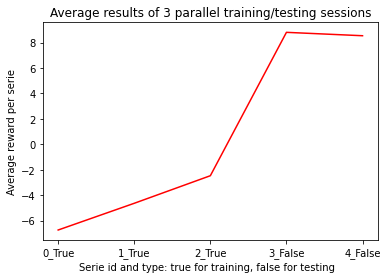

In [ ]:
print(">>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<")
print("In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?")

# ------------ Defining several parameters - others will be chosen by grid search --------------
N_items = 100
N_recommended = 1
memory = 1
choiceMethod =  'QlearningActionsTuples'
rewardType = 'Trust'
behaviour = 'similarWithSubset'
rewardParameters = [1,1]
steps = 20
epochs = 3
train_list = [True for u in range(3) ]+[ False, False ]
p = 0.5

#------------- Defining the environnement  -----------
environnement = Environnement(N_items, N_recommended, behaviour,  rewardType , rewardParameters, proba_p=p )
environnement.items.display(True)


# >>> Grid search over the parameters to get the best parameters
gridSearch = GridSearch()
num_avg = 3
_ , params = gridSearch(num_avg, environnement, memory, choiceMethod, epochs, train_list, steps=steps, more_params = None)



#------------ launching the episode series : Average the learning processes results   ---------------
#(less randomness in the plots), for statistical study, than the Series class
num_avg = 3
epochs = 10
avgSeries = AverageSeries(num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps)
Rewards = avgSeries.avgRewards

plt.figure()
plt.plot([str(i)+"_"+str(train_list[i]) for i in range(len(train_list))],Rewards, 'r-')
plt.ylabel("Average reward per serie")
plt.xlabel("Serie id and type: true for training, false for testing  ")
plt.title("Average results of "+str(num_avg)+" parallel training/testing sessions")
plt.show()

#### Q-Learning (Linear) 

  0%|          | 0/4 [00:00<?, ?it/s]

>>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<
In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?
---------------- Items ----------------
Number of items: 100
*** Items list: ***
Item 0 -> name:Bh0, cost: 0
Item 1 -> name:LhhLoh, cost: 1
Item 2 -> name:MXrCAJ, cost: 1
Item 3 -> name:J4d, cost: 1
Item 4 -> name:AII, cost: 1
Item 5 -> name:UewDDnj1, cost: 1
Item 6 -> name:loIv, cost: 1
Item 7 -> name:12oU, cost: 1
Item 8 -> name:Ufhic, cost: 1
Item 9 -> name:naT5u, cost: 1
Item 10 -> name:CnREA, cost: 1
Item 11 -> name:2h2aW, cost: 0
Item 12 -> name:nAXrM, cost: 1
Item 13 -> name:CD4Xy6, cost: 1
Item 14 -> name:XAVQ, cost: 1
Item 15 -> name:Qss0q, cost: 1
Item 16 -> name:rATip, cost: 1
Item 17 -> name:nWCkjOaMx, cost: 1
Item 18 -> name:gn5lRsS0, cost: 1
Item 19 -> name:wQe9k, cost: 1
Item 20 -> name:pVcoaNf, cost: 1
Item 21 -> name:6prLzox, c

100%|██████████| 4/4 [00:26<00:00,  6.65s/it]


******** Grid Search results : *******
best_reward: 12.222222222222223
best parameters 
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.1, 'learning_rate': 1, 'gamma': 0.5}
**************************************
 
 
 Execution time of grid Search: 26.596111059188843
------------------> Average of series begins:  <------------------
3 independent training/testing processes
environnement name: envi_01
Memory size: 1
Number of items to recommend: 1
--- We will test the following hyperparameters ---
choice method: LinearQlearning
epochs: 10
Reward hyper parameters: [1, 1]
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.1, 'learning_rate': 1, 'gamma': 0.5}


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

 
 
 Execution time: 1.144394874572754
Final weights: 
[[-0.48180419]
 [-0.35500837]
 [ 2.36797438]]
Action list:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99]]
Action ids list:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,

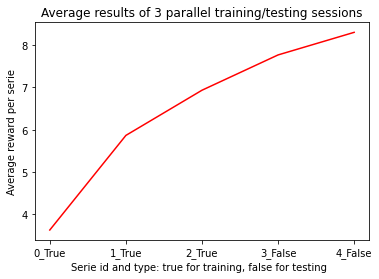

In [ ]:
print(">>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<")
print("In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?")

# ------------ Defining several parameters - others will be chosen by grid search --------------
N_items = 100
N_recommended = 1
memory = 1
choiceMethod =   'LinearQlearning'
rewardType = 'Trust'
behaviour = 'similarWithSubset'
rewardParameters = [1,1]
steps = 10
epochs = 3
train_list = [True for u in range(3) ]+[ False, False ]
p = 0.7

#------------- Defining the environnement  -----------
environnement = Environnement(N_items, N_recommended, behaviour,  rewardType , rewardParameters, proba_p=p )
environnement.items.display(True)

#------------- Defining the environnement  -----------
# >>> Grid search over the parameters to get the best parameters
gridSearch = GridSearch()
num_avg = 3
_ , params = gridSearch(num_avg, environnement, memory, choiceMethod, epochs, train_list, steps=steps)
#params = {'gamma': 0.1, 'hidden_size': 10, 'epsilon': 0.2, 'learning_rate': 0.01, 'QLchoiceMethod': 'eGreedy'}


#------------ launching the episode series : Average the learning processes results   ---------------
#(less randomness in the plots), for statistical study, than the Series class
num_avg = 3
epochs = 10
avgSeries = AverageSeries(num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps)
Rewards = avgSeries.avgRewards


plt.figure()
plt.plot([str(i)+"_"+str(train_list[i]) for i in range(len(train_list))],Rewards, 'r-')
plt.ylabel("Average reward per serie")
plt.xlabel("Serie id and type: true for training, false for testing  ")
plt.title("Average results of "+str(num_avg)+" parallel training/testing sessions")
plt.show()

#### Q-Learning (Deep) 

  0%|          | 0/3 [00:00<?, ?it/s]

>>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER ALWAYS CHOOSES THE FIRST RECOMMENDATION <<<<<<<<<<<<<<<<<<
---------------- Items ----------------
Number of items: 100
*** Items list: ***
Item 0 -> name:NTYh, cost: 0
Item 1 -> name:jhRkyATw, cost: 1
Item 2 -> name:ZlZby1vmi, cost: 1
Item 3 -> name:Oyqx7, cost: 1
Item 4 -> name:Bw5sA2o, cost: 1
Item 5 -> name:PaaDzM, cost: 1
Item 6 -> name:kVrpG6O4, cost: 1
Item 7 -> name:XnZ0l, cost: 1
Item 8 -> name:IebF, cost: 1
Item 9 -> name:l3RL28hj, cost: 1
Item 10 -> name:yWo4Qu, cost: 1
Item 11 -> name:x9po7U9, cost: 0
Item 12 -> name:uvXRAV, cost: 1
Item 13 -> name:pk1Usr5, cost: 1
Item 14 -> name:vTbKCqY, cost: 1
Item 15 -> name:3Gg, cost: 1
Item 16 -> name:kGR1, cost: 1
Item 17 -> name:hutDH6z, cost: 1
Item 18 -> name:Ty1EF, cost: 1
Item 19 -> name:eh3z, cost: 1
Item 20 -> name:dkgumPis, cost: 1
Item 21 -> name:MOBT, cost: 1
Item 22 -> name:pJuTUig, cost: 1
Item 23 -> name:4Pf, cost: 1
Item 24 -> name:QNt5R4P, cost: 1
Item 25 -> name:DN

100%|██████████| 3/3 [02:44<00:00, 54.68s/it]


******** Grid Search results : *******
best_reward: 10.666666666666666
best parameters 
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.1, 'learning_rate': 0.001, 'gamma': 0.9}
**************************************
 
 
 Execution time of grid Search: 164.0341398715973
Testing the Grid Search parameters: 
------------------> Average of series begins:  <------------------
3 independent training/testing processes
environnement name: envi_01
Memory size: 1
Number of items to recommend: 1
--- We will test the following hyperparameters ---
choice method: DeepQlearning
epochs: 10
Reward hyper parameters: [1, 1]
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.1, 'learning_rate': 0.001, 'gamma': 0.9}


100%|██████████| 2/2 [00:15<00:00,  7.59s/it]

 
 
 Execution time: 22.80694317817688
--------------------------> Q learning ( neural network approximation) method :
 memory: 1
 number of items to recommend at each step : 1
 learning rate: 0.001
 gamma: 0.9
trainable layers ids: [0, 2]
Model:
Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

 <---- Weight and bias of Layer 0 ---->
Weight -->
tensor([[-0.2413,  0.2252,  0.0984],
        [ 0.3353,  0.1450,  0.1539],
        [-0.1056, -0.4696, -0.3062],
        [ 0.5668, -0.2561,  0.5004],
        [ 0.5037,  0.1779, -0.1713],
        [ 0.0163, -0.4027,  0.3910],
        [-0.3231, -0.1181,  0.4725],
        [-0.4251, -0.4705, -0.5555],
        [ 0.4235, -0.4544, -0.3605],
        [-0.3410,  0.2591, -0.2932]])
Bias -->
tensor([-0.0537, -0.5448,  0.0845, -0.4466, -0.1894, -0.2364,  0.4316, -0.3399,
        -0.4136,  0.2475])

 <---- Weight and bias of Layer 2 ---->
Weight -->
tensor([[ 0.0459, -0

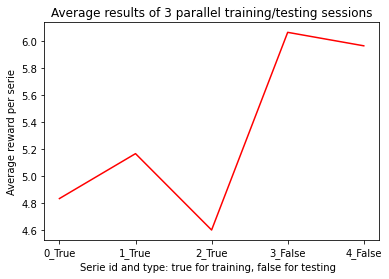

In [ ]:
print(">>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER ALWAYS CHOOSES THE FIRST RECOMMENDATION <<<<<<<<<<<<<<<<<<")
import torch
# ------------ Defining several parameters - others will be chosen by grid search --------------
N_items = 100
N_recommended = 1
memory = 1
choiceMethod =  'DeepQlearning'
rewardType = 'Trust'
behaviour = 'similarWithSubset'
rewardParameters = [1,1]
steps = 10
epochs = 3
train_list = [True for u in range(3) ]+[ False, False ]

#------------- Defining the environnement  -----------
environnement = Environnement(N_items, N_recommended, behaviour,  rewardType , rewardParameters )


environnement.items.display(True)

model = nn.Sequential(
    nn.Linear(memory+2*N_recommended, 10),
    nn.SELU(),
    nn.Linear(10, 1)
)

trainable_layers = [0,2]

deepQModel = {'model': model, 'trainable_layers': trainable_layers}

# >>> Grid search over the parameters to get the best parameters
gridSearch = GridSearch()
num_avg = 3
_ , params = gridSearch(num_avg, environnement, memory, choiceMethod, epochs, train_list, steps=steps, more_params = None, deepQModel=deepQModel)

print("Testing the Grid Search parameters: ")

#------------ launching the episode series : Average the learning processes results   ---------------
#(less randomness in the plots), for statistical study, than the Series class
num_avg = 3
epochs = 10
avgSeries = AverageSeries(num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps, deepQModel)
Rewards = avgSeries.avgRewards


plt.figure()
plt.plot([str(i)+"_"+str(train_list[i]) for i in range(len(train_list))],Rewards, 'r-')
plt.ylabel("Average reward per serie")
plt.xlabel("Serie id and type: true for training, false for testing  ")
plt.title("Average results of "+str(num_avg)+" parallel training/testing sessions")
plt.show()

### "Similar" user  

#### Q-Learning (Action Tuples)

Similar setting than before, with 'similar' user behaviour. 
However:
- the cost of item "2" is 0 all the other ones have a cost of 1
- the item "3" is very similar to all other items (similarity = 0.8), whereas all of the other similarities between items is set to 0.1.

We can see in the results that the item "3" and "2" are the most recommended items. Even though "3" is of cost 1  "3" is more often recommended than the rest, because the reward is set to "trust", and "3" has high similarity scores (and therefore is a "good quality item").
"2" is recommended when "3" is the currently consumed content, as it is the lowest cost item.
The aim of this cell is to show that the agent adapts to both cost and quality.

Note that in this case, the environnement does not allow us to get a best possible reward equal to the number of steps. 

  0%|          | 0/4 [00:00<?, ?it/s]

>>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<
In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?
---------------- Items ----------------
Number of items: 100
*** Items list: ***
Item 0 -> name:ttUx, cost: 1
Item 1 -> name:x3ysKoC, cost: 1
Item 2 -> name:71QV, cost: 1
Item 3 -> name:G3iAZvAD, cost: 0
Item 4 -> name:DrD, cost: 1
Item 5 -> name:yCTKpX, cost: 1
Item 6 -> name:P4qOwqVV, cost: 1
Item 7 -> name:aw6, cost: 1
Item 8 -> name:6IXA7wI8, cost: 1
Item 9 -> name:oodBqN, cost: 1
Item 10 -> name:zR5giatdx, cost: 1
Item 11 -> name:XgmN5, cost: 1
Item 12 -> name:UDuZr, cost: 1
Item 13 -> name:Csim, cost: 1
Item 14 -> name:SV0pd, cost: 1
Item 15 -> name:gvdW, cost: 1
Item 16 -> name:x1iXG4Xj, cost: 1
Item 17 -> name:IO0EA, cost: 1
Item 18 -> name:9ejU, cost: 1
Item 19 -> name:IcTG, cost: 1
Item 20 -> name:D7U, cost: 1
Item 21 -> name:2g4, cos

  0%|          | 0/2 [00:00<?, ?it/s]

******** Grid Search results : *******
best_reward: -0.7777777777777777
best parameters 
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.4, 'learning_rate': 0.1, 'gamma': 0.3}
**************************************
 
 
 Execution time of grid Search: 6.967385768890381
------------------> Average of series begins:  <------------------
3 independent training/testing processes
environnement name: envi_01
Memory size: 1
Number of items to recommend: 1
--- We will test the following hyperparameters ---
choice method: QlearningActionsTuples
epochs: 10
Reward hyper parameters: [1, 1]
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.4, 'learning_rate': 0.1, 'gamma': 0.3}


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]

 
 
 Execution time: 0.2815537452697754
Qtable of the last series ------------------------------>
[[   -inf  0.      0.     ...  0.      0.      0.    ]
 [ 0.        -inf  0.     ...  0.      0.      0.    ]
 [ 0.      0.        -inf ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...    -inf  0.      0.    ]
 [ 0.      0.      0.     ...  0.        -inf  0.    ]
 [-0.0943  0.      0.     ...  0.      0.        -inf]]
---------------------------------------------------->
 
After the learning process : how often  is an item recommended? (total of all series) 
[  1.   0.   1.   3.   0.   1.  53.   3.   1.   0.   0.   0.   0.   0.
   2.   0.   0.   0.   0.   1.   2.   0.   1.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   2.   0.   1.   2.
   1.   0.   3.   3.   0.   0.   0.   0.   3.   0.   1.   0.   0.   0.
   1.   0.   0.   0.   0.   2.   1.   1.   0.   0.   3.   4.   2. 139.
 138.   0.   0.   2.   0.   3.   0.   0.   0.   1.   0.   0.   1.   

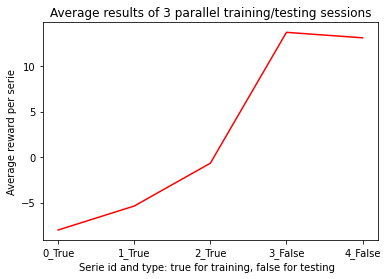

In [ ]:
print(">>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<")
print("In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?")

# ------------ Defining several parameters - others will be chosen by grid search --------------
N_items = 100
N_recommended = 1
memory = 1
choiceMethod =  'QlearningActionsTuples'
rewardType = 'Trust'
behaviour = 'similar'
rewardParameters = [1,1]
steps = 20
epochs = 3
train_list = [True for u in range(3) ]+[ False, False ]
p = 0.5

#------------- Defining the environnement  -----------
environnement = Environnement(N_items, N_recommended, behaviour,  rewardType , rewardParameters, proba_p=p )
environnement.items.display(True)


# >>> Grid search over the parameters to get the best parameters
gridSearch = GridSearch()
num_avg = 3
_ , params = gridSearch(num_avg, environnement, memory, choiceMethod, epochs, train_list, steps=steps, more_params = None)



#------------ launching the episode series : Average the learning processes results   ---------------
#(less randomness in the plots), for statistical study, than the Series class
num_avg = 3
epochs = 10
avgSeries = AverageSeries(num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps)
Rewards = avgSeries.avgRewards

plt.figure()
plt.plot([str(i)+"_"+str(train_list[i]) for i in range(len(train_list))],Rewards, 'r-')
plt.ylabel("Average reward per serie")
plt.xlabel("Serie id and type: true for training, false for testing  ")
plt.title("Average results of "+str(num_avg)+" parallel training/testing sessions")
plt.show()

#### Q-Learning (Linear) 

  0%|          | 0/4 [00:00<?, ?it/s]

>>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<
In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?
---------------- Items ----------------
Number of items: 100
*** Items list: ***
Item 0 -> name:pAZb, cost: 1
Item 1 -> name:i1meR, cost: 1
Item 2 -> name:HQ1LMOA, cost: 1
Item 3 -> name:2WmU9yrB, cost: 0
Item 4 -> name:VdWisK, cost: 1
Item 5 -> name:LtZ, cost: 1
Item 6 -> name:KpxMaNgzS, cost: 1
Item 7 -> name:GAmhPb, cost: 1
Item 8 -> name:bfbuaq3xg, cost: 1
Item 9 -> name:CqxFVuu, cost: 1
Item 10 -> name:8dHb1LfJs, cost: 1
Item 11 -> name:NDqSiJ5, cost: 1
Item 12 -> name:plmIab3, cost: 1
Item 13 -> name:zmk, cost: 1
Item 14 -> name:DpE, cost: 1
Item 15 -> name:nl0r, cost: 1
Item 16 -> name:GtSiYu, cost: 1
Item 17 -> name:Eni, cost: 1
Item 18 -> name:r7YnTfE, cost: 1
Item 19 -> name:tyndxd, cost: 0
Item 20 -> name:aGal, cost: 1
Item 21 -> nam

100%|██████████| 4/4 [00:24<00:00,  6.13s/it]


******** Grid Search results : *******
best_reward: 10.444444444444445
best parameters 
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.4, 'learning_rate': 1, 'gamma': 0.7}
**************************************
 
 
 Execution time of grid Search: 24.53862738609314
------------------> Average of series begins:  <------------------
3 independent training/testing processes
environnement name: envi_01
Memory size: 1
Number of items to recommend: 1
--- We will test the following hyperparameters ---
choice method: LinearQlearning
epochs: 10
Reward hyper parameters: [1, 1]
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.4, 'learning_rate': 1, 'gamma': 0.7}


100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

 
 
 Execution time: 1.0565755367279053
Final weights: 
[[0.6074263 ]
 [0.62303168]
 [2.30037392]]
Action list:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99]]
Action ids list:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7

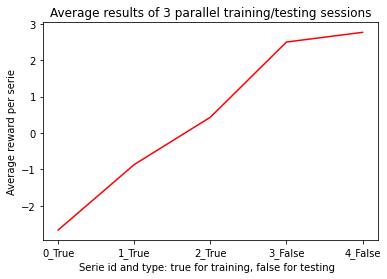

In [ ]:
print(">>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER MAKES SIMILAR CHOICES <<<<<<<<<<<<<<<<<<")
print("In this setting, the number of recommended items is 2. And only 2 items have a cost of 0. But the customer makes similar choices. Will the agent adapt?")

# ------------ Defining several parameters - others will be chosen by grid search --------------
N_items = 100
N_recommended = 1
memory = 1
choiceMethod =   'LinearQlearning'
rewardType = 'Trust'
behaviour = 'similar'
rewardParameters = [1,1]
steps = 10
epochs = 3
train_list = [True for u in range(3) ]+[ False, False ]
p = 0.7

#------------- Defining the environnement  -----------
environnement = Environnement(N_items, N_recommended, behaviour,  rewardType , rewardParameters, proba_p=p )
environnement.items.display(True)

#------------- Defining the environnement  -----------
# >>> Grid search over the parameters to get the best parameters
gridSearch = GridSearch()
num_avg = 3
_ , params = gridSearch(num_avg, environnement, memory, choiceMethod, epochs, train_list, steps=steps)
#params = {'gamma': 0.1, 'hidden_size': 10, 'epsilon': 0.2, 'learning_rate': 0.01, 'QLchoiceMethod': 'eGreedy'}


#------------ launching the episode series : Average the learning processes results   ---------------
#(less randomness in the plots), for statistical study, than the Series class
num_avg = 3
epochs = 10
avgSeries = AverageSeries(num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps)
Rewards = avgSeries.avgRewards


plt.figure()
plt.plot([str(i)+"_"+str(train_list[i]) for i in range(len(train_list))],Rewards, 'r-')
plt.ylabel("Average reward per serie")
plt.xlabel("Serie id and type: true for training, false for testing  ")
plt.title("Average results of "+str(num_avg)+" parallel training/testing sessions")
plt.show()

#### Q-Learning (Deep) 

  0%|          | 0/3 [00:00<?, ?it/s]

>>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER ALWAYS CHOOSES THE FIRST RECOMMENDATION <<<<<<<<<<<<<<<<<<
---------------- Items ----------------
Number of items: 100
*** Items list: ***
Item 0 -> name:u7jV2f0F, cost: 1
Item 1 -> name:w6Ul, cost: 1
Item 2 -> name:iXTP6Ul, cost: 1
Item 3 -> name:lK07OR, cost: 1
Item 4 -> name:xFRbY, cost: 1
Item 5 -> name:wFF, cost: 1
Item 6 -> name:T3PdbD6, cost: 1
Item 7 -> name:V9emyA4, cost: 1
Item 8 -> name:pkSABka, cost: 1
Item 9 -> name:Ypbb2awz, cost: 1
Item 10 -> name:SHok, cost: 1
Item 11 -> name:BVa, cost: 1
Item 12 -> name:61h, cost: 1
Item 13 -> name:gwIBdk, cost: 0
Item 14 -> name:nyFlodfjU, cost: 1
Item 15 -> name:3cWCV, cost: 1
Item 16 -> name:qROXiY, cost: 1
Item 17 -> name:ZdNX, cost: 1
Item 18 -> name:3KSJTB, cost: 1
Item 19 -> name:wP9XaV9vx, cost: 0
Item 20 -> name:Buyn2us, cost: 1
Item 21 -> name:9NBISSe, cost: 1
Item 22 -> name:Kjs9P8BuW, cost: 1
Item 23 -> name:KTE7Q, cost: 1
Item 24 -> name:GqWfNK1, cost: 1
Item 25 -> name

100%|██████████| 3/3 [02:38<00:00, 52.71s/it]


******** Grid Search results : *******
best_reward: 5.444444444444444
best parameters 
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.3, 'learning_rate': 0.1, 'gamma': 0.5}
**************************************
 
 
 Execution time of grid Search: 158.1408088207245
Testing the Grid Search parameters: 
------------------> Average of series begins:  <------------------
3 independent training/testing processes
environnement name: envi_01
Memory size: 1
Number of items to recommend: 1
--- We will test the following hyperparameters ---
choice method: DeepQlearning
epochs: 10
Reward hyper parameters: [1, 1]
{'QLchoiceMethod': 'eGreedy', 'epsilon': 0.3, 'learning_rate': 0.1, 'gamma': 0.5}


100%|██████████| 2/2 [00:14<00:00,  7.29s/it]

 
 
 Execution time: 21.886444091796875
--------------------------> Q learning ( neural network approximation) method :
 memory: 1
 number of items to recommend at each step : 1
 learning rate: 0.1
 gamma: 0.5
trainable layers ids: [0, 2]
Model:
Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

 <---- Weight and bias of Layer 0 ---->
Weight -->
tensor([[ 0.2380, -0.6687, -0.1908],
        [ 0.3465, -0.5230,  0.6571],
        [-0.0415,  0.0031, -0.1102],
        [-0.3351,  0.1396,  0.4381],
        [ 0.0008, -0.4386,  0.2035],
        [-0.0844, -0.0456,  0.4475],
        [ 0.2865,  0.3203, -0.7128],
        [ 0.0068, -0.6268,  0.6780],
        [ 0.5724,  0.1314,  0.5357],
        [-0.3739, -0.0153,  0.6251]])
Bias -->
tensor([ 0.2684, -0.1638,  0.5294,  0.0923,  0.5634,  0.5065, -0.5029, -0.3738,
         0.4189,  0.1353])

 <---- Weight and bias of Layer 2 ---->
Weight -->
tensor([[ 0.2547,  0.

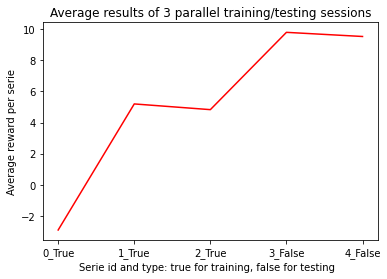

In [ ]:
print(">>>>>>>>>>> TESTING THE AGENT : IN CASE THE CUSTOMER ALWAYS CHOOSES THE FIRST RECOMMENDATION <<<<<<<<<<<<<<<<<<")

# ------------ Defining several parameters - others will be chosen by grid search --------------
N_items = 100
N_recommended = 1
memory = 1
choiceMethod =  'DeepQlearning'
rewardType = 'Trust'
behaviour = 'similar'
rewardParameters = [1,1]
steps = 10
epochs = 3
train_list = [True for u in range(3) ]+[ False, False ]

#------------- Defining the environnement  -----------
environnement = Environnement(N_items, N_recommended, behaviour,  rewardType , rewardParameters )


environnement.items.display(True)


#Create model
#model = nn.Sequential(
#    nn.Linear(memory+2*N_recommended, 20),
#    nn.SELU(),
#    nn.Linear(20, 5),
#    nn.SELU(),
#    nn.Linear(5, 1),
#    nn.Sigmoid()

#)
#trainable_layers = [0,2,4]

model = nn.Sequential(
    nn.Linear(memory+2*N_recommended, 10),
    nn.SELU(),
    nn.Linear(10, 1)
)

trainable_layers = [0,2]

deepQModel = {'model': model, 'trainable_layers': trainable_layers}

# >>> Grid search over the parameters to get the best parameters
gridSearch = GridSearch()
num_avg = 3
_ , params = gridSearch(num_avg, environnement, memory, choiceMethod, epochs, train_list, steps=steps, more_params = None, deepQModel=deepQModel)

print("Testing the Grid Search parameters: ")

#------------ launching the episode series : Average the learning processes results   ---------------
#(less randomness in the plots), for statistical study, than the Series class
num_avg = 3
epochs = 10
avgSeries = AverageSeries(num_avg, environnement, memory, choiceMethod, params, epochs, train_list, steps, deepQModel)
Rewards = avgSeries.avgRewards


plt.figure()
plt.plot([str(i)+"_"+str(train_list[i]) for i in range(len(train_list))],Rewards, 'r-')
plt.ylabel("Average reward per serie")
plt.xlabel("Serie id and type: true for training, false for testing  ")
plt.title("Average results of "+str(num_avg)+" parallel training/testing sessions")
plt.show()